In [1]:
from ClassImplementation import Autoencoder, DenseLayer, GaussianMixtureModel
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from ExternalValidation import *
from InternalValidation import *

np.random.seed(42)

data = load_breast_cancer()
X, y = data.data, data.target

print(f"Total samples: {X.shape[0]}")
print(f"Total features: {X.shape[1]}")

Total samples: 569
Total features: 30


In [2]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

=== Experiment: GMM after Autoencoder ===

Training Autoencoder with bottleneck=2...
Epoch 0, Loss: 0.4589164376644803
Epoch 10, Loss: 0.4260430704991258
Epoch 20, Loss: 0.41998913312481184
Epoch 30, Loss: 0.41915357079696475
Epoch 40, Loss: 0.4184347634664069
  Covariance: full       | BIC: -9398.44
  Covariance: tied       | BIC: -5926.67
  Covariance: diag       | BIC: -9411.12
  Covariance: spherical  | BIC: -6384.47

Training Autoencoder with bottleneck=5...
Epoch 0, Loss: 0.4661317827295836
Epoch 10, Loss: 0.34284987479644663
Epoch 20, Loss: 0.33680909000996734
Epoch 30, Loss: 0.3213310804397385
Epoch 40, Loss: 0.31836553171400916
  Covariance: full       | BIC: -6558.97
  Covariance: tied       | BIC: 2242.10
  Covariance: diag       | BIC: -6168.24
  Covariance: spherical  | BIC: 8652.95

Training Autoencoder with bottleneck=10...
Epoch 0, Loss: 0.48149421927203945
Epoch 10, Loss: 0.3222667709846059
Epoch 20, Loss: 0.299126815362545
Epoch 30, Loss: 0.2910793935634258
Epoch 40, 

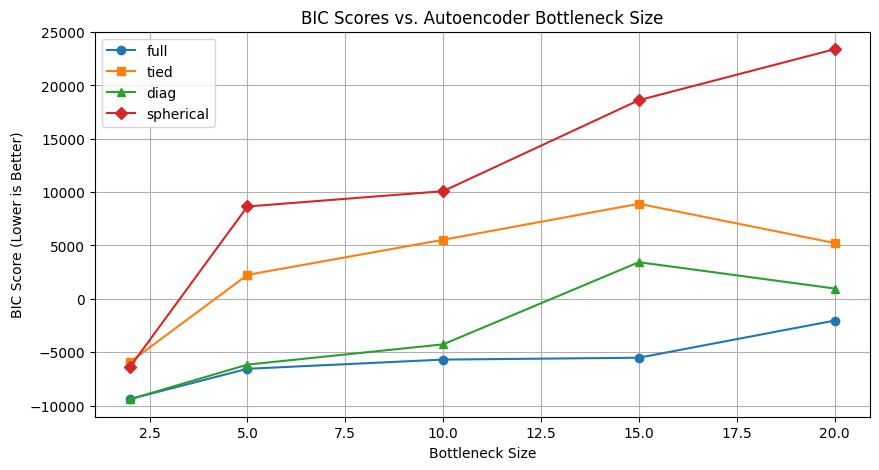


Visualizing Best Model (Bottleneck=2, Covariance='full')...
Epoch 0, Loss: 0.6298602923427189
Epoch 10, Loss: 0.4385779076174708
Epoch 20, Loss: 0.41133994145654634
Epoch 30, Loss: 0.4060015423953005
Epoch 40, Loss: 0.4017068694872898


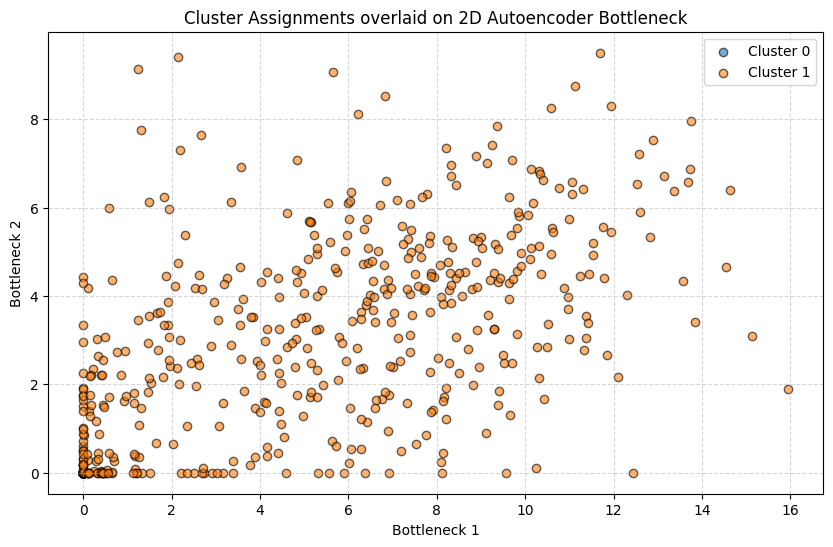

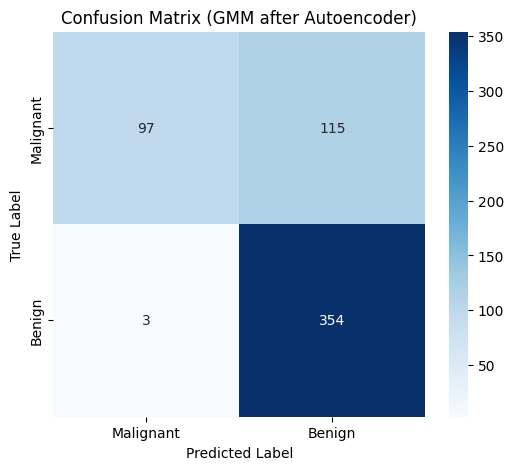


Analysis:
1. The BIC curve shows which covariance type balances complexity and fit best for the Autoencoder bottleneck representations.
2. The Confusion Matrix quantifies how well the unsupervised clusters match the real diagnoses.


In [3]:
print("=== Experiment: GMM after Autoencoder ===")

bottleneck_sizes = [2, 5, 10, 15, 20]
cov_types = ['full', 'tied', 'diag', 'spherical']
bic_scores = {cov: [] for cov in cov_types}

for bottleneck_dim in bottleneck_sizes:
    print(f"\nTraining Autoencoder with bottleneck={bottleneck_dim}...")

    input_dim = X_std.shape[1]
    layers = [
        DenseLayer(input_dim, 64, 'relu'),  
        DenseLayer(64, 32, 'relu'),   
        
        DenseLayer(32, bottleneck_dim, 'relu'),  
        
        DenseLayer(bottleneck_dim, 32, 'relu'),
        DenseLayer(32, 64, 'relu'),
        DenseLayer(64, input_dim, 'relu')  
    ]

    ae = Autoencoder(layers, bottleneck_idx=2)
    ae.train(X_std, epochs=50, batch_size=32, learning_rate=0.01, l2_lambda=1e-4)

    # Encode dataset
    X_encoded = ae.encode(X_std)

    for cov_type in cov_types:
        gmm = GaussianMixtureModel(n_components=2, covariance_type=cov_type, max_iter=100)
        gmm.fit(X_encoded)
        score = gmm.bic(X_encoded)
        bic_scores[cov_type].append(score)
        print(f"  Covariance: {cov_type:10} | BIC: {score:.2f}")

# %% Plot BIC scores
plt.figure(figsize=(10, 5))
markers = ['o', 's', '^', 'D']
for i, cov_type in enumerate(cov_types):
    plt.plot(bottleneck_sizes, bic_scores[cov_type], marker=markers[i], label=cov_type)
plt.title('BIC Scores vs. Autoencoder Bottleneck Size')
plt.xlabel('Bottleneck Size')
plt.ylabel('BIC Score (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

# %% Visualize best model (2D bottleneck, full covariance)
print("\nVisualizing Best Model (Bottleneck=2, Covariance='full')...")
layers_viz = [
    DenseLayer(input_dim, 10, 'relu'),
    DenseLayer(10, 2, 'relu'),
    DenseLayer(2, 10, 'relu'),
    DenseLayer(10, input_dim, 'sigmoid')
]
ae_viz = Autoencoder(layers_viz, bottleneck_idx=1)
ae_viz.train(X_std, epochs=50, batch_size=32, learning_rate=0.01, l2_lambda=1e-4)
X_viz = ae_viz.encode(X_std)

best_gmm = GaussianMixtureModel(n_components=2, covariance_type='full', max_iter=100)
best_gmm.fit(X_viz)
labels = best_gmm.predict(X_viz)

plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e']
for i in range(2):
    mask = (labels == i)
    plt.scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i], label=f'Cluster {i}', alpha=0.6, edgecolors='k')
plt.title('Cluster Assignments overlaid on 2D Autoencoder Bottleneck')
plt.xlabel('Bottleneck 1')
plt.ylabel('Bottleneck 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# %% Confusion Matrix
y_pred_aligned = np.zeros_like(labels)
for cluster in np.unique(labels):
    mask = (labels == cluster)
    if np.sum(mask) > 0:
        true_labels = y[mask]
        mode = np.bincount(true_labels).argmax()
        y_pred_aligned[mask] = mode

cm = np.zeros((2, 2), dtype=int)
for i in range(2):
    for j in range(2):
        cm[i, j] = np.sum((y == i) & (y_pred_aligned == j))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.title('Confusion Matrix (GMM after Autoencoder)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nAnalysis:")
print("1. The BIC curve shows which covariance type balances complexity and fit best for the Autoencoder bottleneck representations.")
print("2. The Confusion Matrix quantifies how well the unsupervised clusters match the real diagnoses.")


#### Getting metrics for GMM + AE


In [4]:
bottleneck_size = 2
layers = [
    DenseLayer(input_dim, 64, 'relu'),
    DenseLayer(64, 32, 'relu'),
    DenseLayer(32, bottleneck_size, 'relu'),
    DenseLayer(bottleneck_size, 32, 'relu'),
    DenseLayer(32, 64, 'relu'),
    DenseLayer(64, input_dim, 'relu')
]
ae = Autoencoder(layers, bottleneck_idx=2)
ae.train(X_std, epochs=100, batch_size=32, learning_rate=0.01, l2_lambda=1e-4)
X_encoded = ae.encode(X_std)
gmm = GaussianMixtureModel(n_components=2, covariance_type='diag', max_iter=100)
gmm.fit(X_encoded)
labels = gmm.predict(X_encoded)

ari = AdjustedRandIndex(y, labels)
nmi = normalized_mutual_info(y, labels)
pur = purity(y, labels)
silhouette = calculate_silhouette_score(X_encoded, labels)
davies_bouldin = calculate_davies_bouldin_index(X_encoded, labels)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Purity: {pur:.4f}")



Epoch 0, Loss: 0.49403790643535184
Epoch 10, Loss: 0.43630984583860805
Epoch 20, Loss: 0.4338821050595128
Epoch 30, Loss: 0.43176738789735714
Epoch 40, Loss: 0.4294228061277203
Epoch 50, Loss: 0.4258788967908821
Epoch 60, Loss: 0.4154206535352381
Epoch 70, Loss: 0.41215704904956885
Epoch 80, Loss: 0.4103506007110313
Epoch 90, Loss: 0.40930638640628775
Adjusted Rand Index: 0.6775
Normalized Mutual Information: 0.5538
Silhouette Score: 0.6967
Davies-Bouldin Index: 0.4923
Purity: 0.9121
